In [8]:
Index(3)

(dim=3|id=851)

In [1]:
using ITensors

In [5]:

angle_list = [0,  ]

1-element Vector{Int64}:
 0

In [2]:
using Pkg

In [294]:
using NPZ
N = 64

# Make an array of N Index objects with alternating
# "S=1/2" and "S=1" tags on odd versus even sites
# (The first argument n->isodd(n) ... is an 
# on-the-fly function mapping integers to strings)

sites = siteinds("S=1/2", N)
entangle_E = []
pa = []
P0_list = []
P1_list = []

angle_list = [0.0, 0.05*pi, 0.1*pi, 0.15*pi, 0.2*pi, 0.25*pi, 0.3*pi, 0.35*pi, 0.4*pi, 0.45*pi, 0.5*pi]
ITensors.op(::OpName"P0",::SiteType"S=1/2") =
 [1 0
  0 0]
ITensors.op(::OpName"P1",::SiteType"S=1/2") =
 [0 0
  0 1]

for angle in angle_list
    all_tensors = []
    os = OpSum()
    os -= 4.0*cos(angle)^2, "Sz",1,"Sx",2
    os -= 4.0*cos(angle)*sin(angle), "Sz",1,"Sz",2
    os += 4.0*sin(angle)^2, "Sx",1,"Sz",2
    os += 4.0*cos(angle)*sin(angle), "Sx",1,"Sx",2
    
    os -= 8.0*cos(angle)^3, "Sx", N-2,"Sz",N-1,"Sz",N
    os -= 8.0*cos(angle)^2*sin(angle), "Sz",N-2,"Sz",N-1, "Sz",N
    os += 8.0*cos(angle)^2*sin(angle), "Sx",N-2,"Sx",N-1, "Sz",N
    os += 8.0*cos(angle)^2*sin(angle), "Sx",N-2,"Sz",N-1, "Sx",N
    os += 8.0*cos(angle)*sin(angle)^2, "Sz",N-2,"Sx",N-1, "Sz",N
    os += 8.0*cos(angle)*sin(angle)^2, "Sz",N-2,"Sz",N-1, "Sx",N
    os -= 8.0*cos(angle)*sin(angle)^2, "Sx",N-2,"Sx",N-1, "Sx",N
    os -= 8.0*sin(angle)^3, "Sz",N-2,"Sx",N-1, "Sx",N
    
    os -= 4.0*cos(angle)^2, "Sx", N-1,"Sx",N
    os -= 4.0*cos(angle)*sin(angle), "Sx", N-1,"Sz",N
    os -= 4.0*sin(angle)^2, "Sz", N-1,"Sz",N
    os -= 4.0*cos(angle)*sin(angle), "Sz", N-1,"Sx",N
    
    for j=1:N-3
        os -= 8.0*cos(angle)^3, "Sx",j,"Sz",j+1,"Sx",j+2
        os -= 8.0*cos(angle)^2*sin(angle), "Sz",j,"Sz",j+1, "Sx", j+2
        os += 8.0*cos(angle)^2*sin(angle), "Sx",j,"Sx",j+1, "Sx", j+2
        os -= 8.0*cos(angle)^2*sin(angle), "Sx",j,"Sz",j+1,"Sz", j+2
        os += 8.0*cos(angle)*sin(angle)^2, "Sz",j,"Sx",j+1, "Sx", j+2
        os += 8.0*cos(angle)*sin(angle)^2, "Sx",j,"Sx",j+1, "Sz", j+2
        os -= 8.0*cos(angle)*sin(angle)^2, "Sz",j,"Sz",j+1,"Sz", j+2
        os += 8.0*sin(angle)^3, "Sz",j,"Sx",j+1,"Sz", j+2
    end
    
    H = MPO(os, sites)
    
    nsweeps = 5
    maxdim = [10,20,40,80,200]
    mindim = [2, 2, 2, 2, 2]
    cutoff = [1E-6]
    noise = [1E-5, 1E-6, 1E-7, 1E-8, 0.0]
    psi0 = randomMPS(sites, 10)
    ang = round(angle, digits = 3)
    
    energy, psi = dmrg(H, psi0; nsweeps, maxdim, mindim, cutoff, noise)
    save_dir = "mps_tensors"
    isdir(save_dir) || mkdir(save_dir)  # Create the directory if it doesn't exist
    
    # Save the initial tensor as an .npy file
    
    tensor = psi[1]
    tensor_array = Array(tensor, siteinds(psi, 1), linkinds(psi, 1))  # Convert the ITensor to a dense array
    file_path = joinpath(save_dir, "tensor_init_$(N)_angle_$(ang).npy")  # File path for the .npy file
    npzwrite(file_path, tensor_array)  # Save the array as an .npy file
    # Iterate over each site in the MPS and save the tensor as an .npy file
    
    for i in 2:length(psi)-1
        tensor = psi[i] # Convert the ITensor to a dense array
        tensor_array = Array(tensor, siteinds(psi, i), linkinds(psi, i), linkinds(psi, i-1))  # Convert the ITensor to a dense array
        push!(all_tensors, tensor_array) 
    end
    
    file_path = joinpath(save_dir, "tensor_$(N)_angle_$(ang).npy")  # File path for the .npy file
    stacked_tensor = cat(all_tensors..., dims=ndims(all_tensors[1]) + 1)
    npzwrite(file_path, stacked_tensor)  # Save the array as an .npy file
    tensor = psi[length(psi)]
    tensor_array = Array(tensor, siteinds(psi, length(psi)), linkinds(psi, length(psi)-1))  # Convert the ITensor to a dense array
    file_path = joinpath(save_dir, "tensor_last_$(N)_angle_$(ang).npy")  # File path for the .npy file
    npzwrite(file_path, tensor_array)  # Save the array as an .npy file
    
    sample_array = [] 
    for i in 1:1024
        push!(sample_array, sample(psi))
    end
    sample_array = transpose(hcat(sample_array...))
    file_path = joinpath(save_dir, "sample_$(N)_angle_$(ang).npy")  # File path for the .npy file
    npzwrite(file_path, Array(sample_array))  # Save the array as an .npy file
end




After sweep 1 energy=-63.999538005897236  maxlinkdim=5 maxerr=1.84E-03 time=0.886
After sweep 2 energy=-64.00000000000011  maxlinkdim=2 maxerr=4.10E-09 time=2.321
After sweep 3 energy=-64.00000000000003  maxlinkdim=2 maxerr=5.91E-16 time=0.225
After sweep 4 energy=-64.00000000000003  maxlinkdim=2 maxerr=5.62E-16 time=0.236
After sweep 5 energy=-63.99999999999994  maxlinkdim=2 maxerr=7.77E-16 time=0.261
After sweep 1 energy=-63.999646768887374  maxlinkdim=4 maxerr=1.20E-03 time=0.307
After sweep 2 energy=-64.00000000000003  maxlinkdim=2 maxerr=2.79E-09 time=0.286
After sweep 3 energy=-63.99999999999989  maxlinkdim=2 maxerr=6.02E-16 time=0.161
After sweep 4 energy=-64.00000000000001  maxlinkdim=2 maxerr=5.53E-16 time=0.233
After sweep 5 energy=-64.00000000000009  maxlinkdim=2 maxerr=5.64E-16 time=0.159
After sweep 1 energy=-63.999702126651115  maxlinkdim=3 maxerr=1.59E-03 time=0.275
After sweep 2 energy=-64.00000000000009  maxlinkdim=2 maxerr=9.99E-09 time=0.165
After sweep 3 energy=-63.

In [101]:
using NPZ, LinearAlgebra, TensorOperations, SparseArrays, Combinatorics

# Load the MPS tensors
L = 4
p = 1
ang = round(pi/2, digits = 3)
M0 = npzread("mps_tensors/tensor_init_$(L * p)_angle_$(ang).npy")
M = npzread("mps_tensors/tensor_$(L * p)_angle_$(ang).npy")
Mlast = npzread("mps_tensors/tensor_last_$(L * p)_angle_$(ang).npy")
println(length(Mlast[1, :]))

2


In [157]:
N = 4
s = siteinds("S=1/2", N)
amp = zeros(Float64, 2^L)
amp_ = zeros(Float64, 2^L)

for config in eachindex(amp)
    config_bits = digits(config-1, base=2, pad=L) .+ 1
    println(config_bits)
    vec_init = M0[config_bits[1] , :]
    for i in 2:(L-1)
        vec_init = M[config_bits[i] , :, :, i-1] * vec_init
        
    end
    amp[config] = dot(vec_init, Mlast[config_bits[end], :])
    V = ITensor(1.)
    for j=1:N
      V *= (psi[j]*state(s[j], config_bits[j]))
    end
    amp_[config] = scalar(V)
end

# Normalize the amplitude
amp /= norm(amp)
amp_ /= norm(amp_)
println(amp)
println(amp_)


[1, 1, 1, 1]


LoadError: DimensionMismatch: In scalar(T) or T[], ITensor T is not a scalar (it has indices ((dim=2|id=807|"S=1/2,Site,n=1"), (dim=2|id=70|"S=1/2,Site,n=1"), (dim=2|id=267|"S=1/2,Site,n=2"), (dim=2|id=695|"S=1/2,Site,n=2"), (dim=2|id=191|"S=1/2,Site,n=3"), (dim=2|id=790|"S=1/2,Site,n=3"), (dim=2|id=893|"S=1/2,Site,n=4"), (dim=2|id=873|"S=1/2,Site,n=4"))).

In [210]:
using ITensors
N = 4
s = siteinds("S=1/2", N)
println(psi)
# Make an array of integers of the element we
# want to obtain
el = [1,2,1,1]

V = ITensor(1.)
V *= (state(s[1], el[1])*psi[1])
V *= (psi[2]*state(s[2], el[2]))


MPS
[1] ((dim=2|id=798|"Link,l=1"), (dim=2|id=750|"S=1/2,Site,n=1"))
[2] ((dim=2|id=475|"Link,l=2"), (dim=2|id=128|"S=1/2,Site,n=2"), (dim=2|id=798|"Link,l=1"))
[3] ((dim=2|id=630|"S=1/2,Site,n=3"), (dim=2|id=475|"Link,l=3"), (dim=2|id=475|"Link,l=2"))
[4] ((dim=2|id=255|"S=1/2,Site,n=4"), (dim=2|id=475|"Link,l=3"))


ITensor ord=5 (dim=2|id=930|"S=1/2,Site,n=1") (dim=2|id=750|"S=1/2,Site,n=1") (dim=2|id=475|"Link,l=2") (dim=2|id=128|"S=1/2,Site,n=2") (dim=2|id=302|"S=1/2,Site,n=2")
NDTensors.Dense{Float64, Vector{Float64}}

In [238]:
println(psi[2])

ITensor ord=3
Dim 1: (dim=2|id=838|"Link,l=2")
Dim 2: (dim=2|id=886|"S=1/2,Site,n=2")
Dim 3: (dim=2|id=295|"Link,l=1")
NDTensors.Dense{Float64, Vector{Float64}}
 2×2×2
[:, :, 1] =
  0.9496729099371551  -1.7338884521298653e-16
 -0.3132432986218471   0.0

[:, :, 2] =
 8.70352599602922e-17   0.3132432986218475
 9.047962047256358e-17  0.9496729099371553


In [239]:
Array(psi[2],  siteind(psi, 2), linkinds(psi, 1), linkinds(psi, 2))

2×2×2 Array{Float64, 3}:
[:, :, 1] =
  0.949673     8.70353e-17
 -1.73389e-16  0.313243

[:, :, 2] =
 -0.313243  9.04796e-17
  0.0       0.949673

In [240]:
Array(psi[2],  linkinds(psi, 2), siteind(psi, 2) , linkinds(psi, 1))

2×2×2 Array{Float64, 3}:
[:, :, 1] =
  0.949673  -1.73389e-16
 -0.313243   0.0

[:, :, 2] =
 8.70353e-17  0.313243
 9.04796e-17  0.949673

In [235]:
println(psi[1])

ITensor ord=2
Dim 1: (dim=2|id=295|"Link,l=1")
Dim 2: (dim=2|id=396|"S=1/2,Site,n=1")
NDTensors.Dense{Float64, Vector{Float64}}
 2×2
 -0.5000000000000001  0.5000000000000002
  0.4999999999999999  0.49999999999999994


In [151]:
Pkg.add("ITensorMPS")

   Resolving package versions...
   Installed GR_jll ────────────────── v0.73.7+0
   Installed Opus_jll ──────────────── v1.3.3+0
   Installed HypergeometricFunctions ─ v0.3.24
   Installed libfdk_aac_jll ────────── v2.0.3+0
   Installed libdecor_jll ──────────── v0.2.2+0
   Installed Accessors ─────────────── v0.1.37
   Installed Referenceables ────────── v0.1.3
   Installed Unitful ───────────────── v1.21.0
   Installed ZygoteRules ───────────── v0.2.5
   Installed ConcurrentUtilities ───── v2.4.2
   Installed StaticArrays ──────────── v1.9.7
   Installed HalfIntegers ──────────── v1.6.0
   Installed InlineStrings ─────────── v1.4.2
   Installed Static ────────────────── v0.8.9
   Installed EllipsisNotation ──────── v1.8.0
   Installed Pango_jll ─────────────── v1.54.1+0
   Installed Functors ──────────────── v0.4.12
   Installed LinearMaps ────────────── v3.11.3
   Installed Hwloc_jll ─────────────── v2.11.1+0
   Installed HarfBuzz_jll ──────────── v8.3.1+0
   Installed TupleTools ─

In [106]:

N = 4
sites = siteinds("S=1/2", N)
angle = pi/2
os = OpSum()
os -= 4.0*cos(angle)^2, "Sz",1,"Sx",2
os += 4.0*cos(angle)*sin(angle), "Sz",1,"Sz",2
os += 4.0*sin(angle)^2, "Sx",1,"Sz",2
os -= 4.0*cos(angle)*sin(angle), "Sx",1,"Sx",2

os -= 8.0*cos(angle)^3, "Sx", N-2,"Sz",N-1,"Sz",N
os += 8.0*cos(angle)^2*sin(angle), "Sz",N-2,"Sz",N-1, "Sz",N
os -= 8.0*cos(angle)^2*sin(angle), "Sx",N-2,"Sx",N-1, "Sz",N
os -= 8.0*cos(angle)^2*sin(angle), "Sx",N-2,"Sz",N-1, "Sx",N
os += 8.0*cos(angle)*sin(angle)^2, "Sz",N-2,"Sx",N-1, "Sz",N
os += 8.0*cos(angle)*sin(angle)^2, "Sz",N-2,"Sz",N-1, "Sx",N
os -= 8.0*cos(angle)*sin(angle)^2, "Sx",N-2,"Sx",N-1, "Sx",N
os += 8.0*sin(angle)^3, "Sz",N-2,"Sx",N-1, "Sx",N

os -= 4.0*cos(angle)^2, "Sx", N-1,"Sx",N
os += 4.0*cos(angle)*sin(angle), "Sx", N-1,"Sz",N
os -= 4.0*sin(angle)^2, "Sz", N-1,"Sz",N
os += 4.0*cos(angle)*sin(angle), "Sz", N-1,"Sx",N
for j=1:N-3
    os -= 8.0*cos(angle)^3, "Sx",j,"Sz",j+1,"Sx",j+2
    os += 8.0*cos(angle)^2*sin(angle), "Sz",j,"Sz",j+1, "Sx", j+2
    os -= 8.0*cos(angle)^2*sin(angle), "Sx",j,"Sx",j+1, "Sx", j+2
    os += 8.0*cos(angle)^2*sin(angle), "Sx",j,"Sz",j+1,"Sz", j+2
    os += 8.0*cos(angle)*sin(angle)^2, "Sz",j,"Sx",j+1, "Sx", j+2
    os += 8.0*cos(angle)*sin(angle)^2, "Sx",j,"Sx",j+1, "Sz", j+2
    os -= 8.0*cos(angle)*sin(angle)^2, "Sz",j,"Sz",j+1,"Sz", j+2
    os -= 8.0*sin(angle)^3, "Sz",j,"Sx",j+1,"Sz", j+2
end

H = MPO(os,sites)

Hitensor = ITensor(1.)
for i = 1:N
    Hitensor *= H[i]
end
A=reshape(Array(Hitensor,sites[1]',sites[2]',sites[3]',sites[4]',sites[1],sites[2],sites[3], sites[4]), 2^N, 2^N)

16×16 Matrix{Float64}:
 -1.0           1.0          -1.0          …  -6.12323e-17   0.0
  1.0          -1.0           6.12323e-17      0.0          -6.12323e-17
 -1.0           6.12323e-17  -1.0             -1.0           0.0
  6.12323e-17   1.0          -1.0              0.0          -1.0
  1.22465e-16  -2.29585e-49   6.12323e-17      3.7494e-33    0.0
 -2.29585e-49   1.22465e-16  -3.7494e-33   …   0.0           3.7494e-33
  6.12323e-17  -3.7494e-33    0.0              0.0           0.0
 -3.7494e-33   -6.12323e-17   2.29585e-49      0.0           0.0
  1.22465e-16   0.0          -3.7494e-33       6.12323e-17  -3.7494e-33
  0.0           1.22465e-16   0.0             -3.7494e-33   -6.12323e-17
 -3.7494e-33    0.0           0.0          …   0.0           2.29585e-49
  0.0          -3.7494e-33    0.0              2.29585e-49   0.0
  1.0           0.0          -6.12323e-17      1.0          -6.12323e-17
  0.0           1.0           0.0             -6.12323e-17  -1.0
 -6.12323e-17   0.0  

In [107]:
dot(amp, A * amp)/dot(amp, amp)

2.4036578644878164

In [33]:
tensor = psi0[4]
tensor_array = Array(tensor, siteind(psi0, 4), linkinds(psi0, 3), linkinds(psi0, 4))

2×8×4 Array{Float64, 3}:
[:, :, 1] =
 -0.490313  -0.0478268  -0.326273  …  -0.308198   0.0661106  0.401777
 -0.311672   0.277038   -0.278362      0.0190209  0.445235   0.130894

[:, :, 2] =
  0.152654  0.440497  0.100007  -0.425629  …  0.315278   0.635239   -0.222787
 -0.513928  0.26776   0.195536  -0.240433     0.187549  -0.0519228   0.229738

[:, :, 3] =
 -0.0328944  -0.329363  0.75791   0.112272  …  -0.205562   0.379241  0.32846
  0.0899603   0.568471  0.308863  0.14258       0.202413  -0.466615  0.364079

[:, :, 4] =
 -0.09607  -0.470837   -0.110298  …  0.825692    0.00730478   0.228729
 -0.59718  -0.0436275   0.292976     0.0712909  -0.17194     -0.652895

In [35]:
for i in 1:5
    println(i)
end

1
2
3
4
5


In [4]:

N = 64

# Make an array of N Index objects with alternating
# "S=1/2" and "S=1" tags on odd versus even sites
# (The first argument n->isodd(n) ... is an 
# on-the-fly function mapping integers to strings)

sites = siteinds("S=1/2", N)
entangle_E = []
pa = []
N = 64
i = 2
b = 2
P0_list = []
P1_list = []

ITensors.op(::OpName"P0",::SiteType"S=1/2") =
 [1 0
  0 0]
ITensors.op(::OpName"P1",::SiteType"S=1/2") =
 [0 0
  0 1]

for angle in angle_list
    os = OpSum()
    os -= 4.0*cos(angle)^2, "Sz",1,"Sx",2
    os += 4.0*cos(angle)*sin(angle), "Sz",1,"Sz",2
    os += 4.0*sin(angle)^2, "Sx",1,"Sz",2
    os -= 4.0*cos(angle)*sin(angle), "Sx",1,"Sx",2
    
    os -= 8.0*cos(angle)^3, "Sx", N-2,"Sz",N-1,"Sz",N
    os += 8.0*cos(angle)^2*sin(angle), "Sz",N-2,"Sz",N-1, "Sz",N
    os -= 8.0*cos(angle)^2*sin(angle), "Sx",N-2,"Sx",N-1, "Sz",N
    os -= 8.0*cos(angle)^2*sin(angle), "Sx",N-2,"Sz",N-1, "Sx",N
    os += 8.0*cos(angle)*sin(angle)^2, "Sz",N-2,"Sx",N-1, "Sz",N
    os += 8.0*cos(angle)*sin(angle)^2, "Sz",N-2,"Sz",N-1, "Sx",N
    os -= 8.0*cos(angle)*sin(angle)^2, "Sx",N-2,"Sx",N-1, "Sx",N
    os += 8.0*sin(angle)^3, "Sz",N-2,"Sx",N-1, "Sx",N
    
    os -= 4.0*cos(angle)^2, "Sx", N-1,"Sx",N
    os += 4.0*cos(angle)*sin(angle), "Sx", N-1,"Sz",N
    os -= 4.0*sin(angle)^2, "Sz", N-1,"Sz",N
    os += 4.0*cos(angle)*sin(angle), "Sz", N-1,"Sx",N
    for j=1:N-3
        os -= 8.0*cos(angle)^3, "Sx",j,"Sz",j+1,"Sx",j+2
        os += 8.0*cos(angle)^2*sin(angle), "Sz",j,"Sz",j+1, "Sx", j+2
        os -= 8.0*cos(angle)^2*sin(angle), "Sx",j,"Sx",j+1, "Sx", j+2
        os += 8.0*cos(angle)^2*sin(angle), "Sx",j,"Sz",j+1,"Sz", j+2
        os += 8.0*cos(angle)*sin(angle)^2, "Sz",j,"Sx",j+1, "Sx", j+2
        os += 8.0*cos(angle)*sin(angle)^2, "Sx",j,"Sx",j+1, "Sz", j+2
        os -= 8.0*cos(angle)*sin(angle)^2, "Sz",j,"Sz",j+1,"Sz", j+2
        os -= 8.0*sin(angle)^3, "Sz",j,"Sx",j+1,"Sz", j+2
    end

    H = MPO(os,sites)

    nsweeps = 5
    maxdim = [10,20,40,80,200]
    cutoff = [1E-10]
    mind = [3, 3, 3, 3, 3]
    noise = [1E-5, 1E-6, 1E-7, 1E-8, 0.0]
    psi0 = randomMPS(sites,10)

    energy, psi = dmrg(H, psi0; nsweeps, maxdim, mind, cutoff, noise)
    println(psi)
    for i in 2:12
        # Apply the projection operator to the MPS at site i
        entangle_Ei = 0
        for a in 1:2^(i-1)
            pa_i = 1
            ind = 2
            psi_i = deepcopy(psi)
            combination = digits(a, base = 2, pad = i - 1)
            reverse!(combination)
            for com in combination
                if com == 0
                    new_psi_i = op("P0", sites[ind])*psi_i[ind]
                    noprime!(new_psi_i)
                    psi_i[ind] = new_psi_i
                    ind += 1
                else
                    new_psi_i = op("P1", sites[ind])*psi_i[ind]
                    noprime!(new_psi_i)
                    psi_i[ind] = new_psi_i
                    ind += 1 
                end
            end
            
            pa_i = inner(psi, psi_i)
            
             # Normalize the MPS
            if inner(psi, psi_i) > 1e-32
                normalize!(psi_i)
                orthogonalize!(psi_i, b)
                U,S,V = svd(psi_i[b], (linkind(psi_i, b-1), siteind(psi_i,b)))
                SvN = 0.0
                for n=1:dim(S, 1)
                    p = S[n,n]^2
                    println(p)
                    SvN -= p * log(p+1e-32)
                end
                entangle_Ei += SvN*pa_i
            end
        end
        push!(entangle_E, entangle_Ei)
    end
end


After sweep 1 energy=-63.9993007406462  maxlinkdim=10 maxerr=1.07E-03 time=17.762
After sweep 2 energy=-63.999999976397376  maxlinkdim=6 maxerr=9.96E-11 time=0.128
After sweep 3 energy=-63.99999999999997  maxlinkdim=2 maxerr=2.63E-12 time=0.090
After sweep 4 energy=-63.99999999999987  maxlinkdim=2 maxerr=5.77E-16 time=0.097
After sweep 5 energy=-64.0000000000001  maxlinkdim=2 maxerr=6.42E-16 time=0.661
MPS
[1] ((dim=2|id=576|"Link,l=1"), (dim=2|id=573|"S=1/2,Site,n=1"))
[2] ((dim=2|id=423|"Link,l=2"), (dim=2|id=811|"S=1/2,Site,n=2"), (dim=2|id=576|"Link,l=1"))
[3] ((dim=2|id=722|"S=1/2,Site,n=3"), (dim=2|id=497|"Link,l=3"), (dim=2|id=423|"Link,l=2"))
[4] ((dim=2|id=727|"S=1/2,Site,n=4"), (dim=2|id=30|"Link,l=4"), (dim=2|id=497|"Link,l=3"))
[5] ((dim=2|id=570|"S=1/2,Site,n=5"), (dim=2|id=415|"Link,l=5"), (dim=2|id=30|"Link,l=4"))
[6] ((dim=2|id=872|"S=1/2,Site,n=6"), (dim=2|id=354|"Link,l=6"), (dim=2|id=415|"Link,l=5"))
[7] ((dim=2|id=836|"S=1/2,Site,n=7"), (dim=2|id=31|"Link,l=7"), (di

LoadError: InterruptException:

In [12]:
sites = siteinds("S=1/2", 6)
println(sites)
println(sites[2])

Index{Int64}[(dim=2|id=656|"S=1/2,Site,n=1"), (dim=2|id=819|"S=1/2,Site,n=2"), (dim=2|id=829|"S=1/2,Site,n=3"), (dim=2|id=930|"S=1/2,Site,n=4"), (dim=2|id=437|"S=1/2,Site,n=5"), (dim=2|id=482|"S=1/2,Site,n=6")]
(dim=2|id=819|"S=1/2,Site,n=2")


In [8]:
println(entangle_E)

Any[]


In [85]:
reshaped_array = reshape(log.(abs.(entangle_E)), 11, 11)'


11×11 adjoint(::Matrix{Float64}) with eltype Float64:
  -0.654195   -0.500044   -0.431051  …   -0.36749    -0.367001   -0.366757
  -0.678013   -0.536835   -0.484383      -0.526951   -0.544089   -0.561366
  -0.750534   -0.64982    -0.647066      -1.00344    -1.0719     -1.13997
  -0.87514    -0.847458   -0.9288        -1.8085     -1.96168    -2.11398
  -1.05818    -1.14613    -1.35164       -2.98837    -3.2645     -3.53904
  -1.31048    -1.57439    -1.96073   …   -4.64276    -5.08841    -5.53355
  -1.65078    -2.18095    -2.84305       -6.99934    -7.67952    -8.36817
  -2.11517    -3.05354    -4.15887      -10.5504    -11.6211    -12.6611
  -2.78827    -4.38485    -6.22719      -18.5197    -20.6143    -22.7146
  -3.9579     -6.8048    -10.0077       -31.0534    -36.0501    -34.5633
 -34.1341    -34.3854    -35.415     …  -35.3408    -34.8189    -34.6889

In [89]:
println(reshaped_array[2, :])

[-0.6780132502723396, -0.5368348487169715, -0.4843833373525596, -0.46885541492580374, -0.47064503682049547, -0.480590164589687, -0.4944681544151304, -0.5102792923276604, -0.5269509159460932, -0.5440893613254881, -0.5613661386761438]


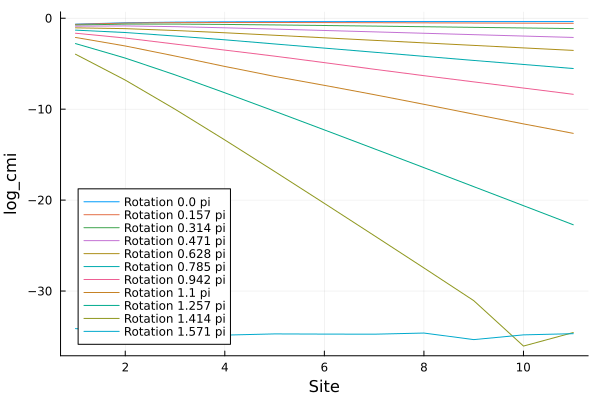

In [74]:
using Plots


# Number of lines (rows of the array)
num_lines = size(reshaped_array, 1)

# Create a plot with multiple lines
p = plot()
for i in 1:num_lines
    angle = round(angle_list[i], digits = 3)
    plot!(1:size(reshaped_array, 2), reshaped_array[i, :], label = "Rotation $angle pi")
end
xlabel!(p, "Site")
ylabel!(p, "log_cmi")
# Display the plot
display(p)


In [70]:
using Pkg
Pkg.add("GLM")

   Resolving package versions...
   Installed StatsFuns ─────────────── v1.3.0
   Installed Rmath_jll ─────────────── v0.4.0+0
   Installed PDMats ────────────────── v0.11.31
   Installed HypergeometricFunctions ─ v0.3.23
   Installed GLM ───────────────────── v1.9.0
   Installed Calculus ──────────────── v0.5.1
   Installed StatsModels ───────────── v0.7.3
   Installed DualNumbers ───────────── v0.6.8
   Installed Rmath ─────────────────── v0.7.1
   Installed OpenSpecFun_jll ───────── v0.5.5+0
   Installed ShiftedArrays ─────────── v2.0.0
   Installed QuadGK ────────────────── v2.9.1
   Installed SpecialFunctions ──────── v2.3.1
   Installed FillArrays ────────────── v1.9.3
   Installed Distributions ─────────── v0.25.104
    Updating `C:\Users\Administrator\.julia\environments\v1.9\Project.toml`
  [38e38edf] + GLM v1.9.0
    Updating `C:\Users\Administrator\.julia\environments\v1.9\Manifest.toml`
  [49dc2e85] + Calculus v0.5.1
  [31c24e10] + Distributions v0.25.104
  [fa6b7ba4] + Dua

In [83]:
println(reshaped_array)

[-0.6541949930334449 -0.5000443132061866 -0.4310514417192354 -0.3982616188962449 -0.38226127754980327 -0.374356098042689 -0.37042681990279847 -0.36846795541746513 -0.3674899602294885 -0.36700132107978234 -0.36675709101387116; -0.6780132502723396 -0.5368348487169715 -0.4843833373525596 -0.46885541492580374 -0.47064503682049547 -0.480590164589687 -0.4944681544151304 -0.5102792923276604 -0.5269509159460932 -0.5440893613254881 -0.5613661386761438; -0.7505336933653614 -0.6498196135988014 -0.6470657417225245 -0.6836719432635511 -0.7382898884764254 -0.8012403518931883 -0.8673878901496878 -0.9353346462651203 -1.0034373978112148 -1.0718974576644538 -1.139973714524838; -0.8751396467131409 -0.8474581237116142 -0.9287999380179401 -1.0532697805490556 -1.1966233100040342 -1.3478377420931547 -1.5009674447659873 -1.6549501550879309 -1.8085031382719743 -1.961681124160134 -2.113984814424079; -1.0581828477688329 -1.1461340989640683 -1.3516429505485694 -1.6002080800033864 -1.874428255065366 -2.15371126464

In [93]:

using GLM

# Example data
x = [1,2,3,4,5,6,7,8,9,10,11]  # Predictor variable
X = hcat(ones(length(x)), x)
slope_list = []
slope_error_list = []
for i in 1:length(angle_list)-1
    y = reshaped_array[i, :]    # Response variable
    model = lm(X, y)

    # Get standard errors of the coefficients
    coefficients = coef(model)
    coeff_errors = stderror(model)
    
    # The standard error of the slope is the second element
    slope = coefficients[2]
    slope_error = coeff_errors[2]
    
    println("Slope: ", slope)
    println("Standard error of the slope: ", slope_error)
    push!(slope_list, slope)
    push!(slope_error_list, slope_error)
end

Slope: 0.020286070069793587
Standard error of the slope: 0.0058135839379222145
Slope: 0.002907671812436001
Standard error of the slope: 0.005959471240601643
Slope: -0.04851863507274976
Standard error of the slope: 0.006262911482306906
Slope: -0.1345266574995507
Standard error of the slope: 0.006560667455971392
Slope: -0.25970580594515486
Standard error of the slope: 0.006751886011852888
Slope: -0.4342059602464314
Standard error of the slope: 0.006598591954030568
Slope: -0.6828697346489571
Standard error of the slope: 0.005774661209660949
Slope: -1.0591581121065976
Standard error of the slope: 0.004566880999911794
Slope: -2.0182926278329214
Standard error of the slope: 0.01956677708477406
Slope: -3.3485577081322733
Standard error of the slope: 0.11308197652843939


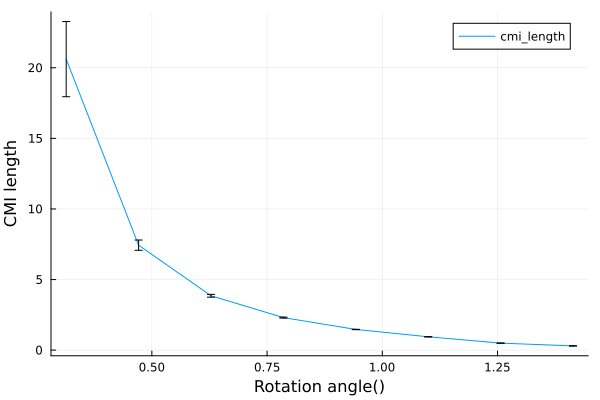

In [103]:
p = plot(angle_list[3:end-1], -1 ./ slope_list[3:end], yerr = (1 ./ slope_list[3:end]).^2 .* slope_error_list[3:end], label = "cmi_length")
xlabel!(p, "Rotation angle()")
ylabel!(p, "CMI length")

In [53]:
println(1e-32)

1.0e-32


In [116]:
N = 10
s = siteinds(2,N)
chi = 4
psi = randomMPS(s;linkdims=chi)

# Make an array of integers of the element we
# want to obtain
el = [1,2,1,1,2,1,2,2,2,1]

V = ITensor(1.)
V *= (psi[1]*state(s[1],el[1]))
v = scalar(V)

# v is the element we wanted to obtain:
@show v

v = 0.0026343181003195197


0.0026343181003195197